In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
import random
words = open('Indian_Names.txt', 'r').read().splitlines()

random.shuffle(words)
words = [w.lower() for w in words]
words[:8]

['madhukavin',
 'yanushitha',
 'kritheikaa',
 'parivadhana',
 'kirtinath',
 'vrisangan',
 'hasvanth',
 'mamata']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([390282, 3]) torch.Size([390282])
torch.Size([48788, 3]) torch.Size([48788])
torch.Size([49004, 3]) torch.Size([49004])


In [32]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [37]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



      0/ 200000: 3.2395
  10000/ 200000: 2.0379
  20000/ 200000: 1.5072
  30000/ 200000: 2.2684
  40000/ 200000: 2.0566
  50000/ 200000: 1.6243
  60000/ 200000: 2.1941
  70000/ 200000: 2.1397
  80000/ 200000: 1.8008
  90000/ 200000: 2.0520
 100000/ 200000: 1.9520
 110000/ 200000: 1.9879
 120000/ 200000: 1.7392
 130000/ 200000: 1.7774
 140000/ 200000: 2.0300
 150000/ 200000: 1.5310
 160000/ 200000: 1.8264
 170000/ 200000: 1.9045
 180000/ 200000: 1.7838
 190000/ 200000: 1.7353


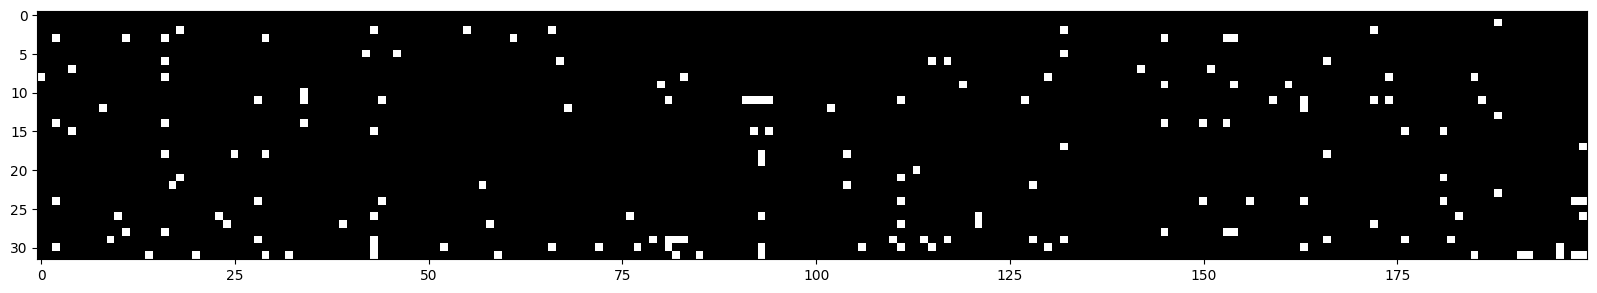

In [34]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

(array([218., 222., 191., 175., 153., 132., 146., 111.,  96., 139., 101.,
         97., 109.,  80., 104.,  91.,  82., 105., 100., 106., 108.,  93.,
         96.,  86.,  86.,  99.,  86., 101.,  85.,  89.,  67., 117., 105.,
        108.,  93., 102., 105., 113., 130., 103., 127., 140., 142., 158.,
        152., 164., 189., 213., 241., 344.]),
 array([-9.99887943e-01, -9.59897236e-01, -9.19906528e-01, -8.79915820e-01,
        -8.39925113e-01, -7.99934405e-01, -7.59943697e-01, -7.19952990e-01,
        -6.79962282e-01, -6.39971575e-01, -5.99980867e-01, -5.59990159e-01,
        -5.19999452e-01, -4.80008744e-01, -4.40018036e-01, -4.00027329e-01,
        -3.60036621e-01, -3.20045913e-01, -2.80055206e-01, -2.40064498e-01,
        -2.00073791e-01, -1.60083083e-01, -1.20092375e-01, -8.01016676e-02,
        -4.01109600e-02, -1.20252371e-04,  3.98704553e-02,  7.98611629e-02,
         1.19851871e-01,  1.59842578e-01,  1.99833286e-01,  2.39823993e-01,
         2.79814701e-01,  3.19805409e-01,  3.59796

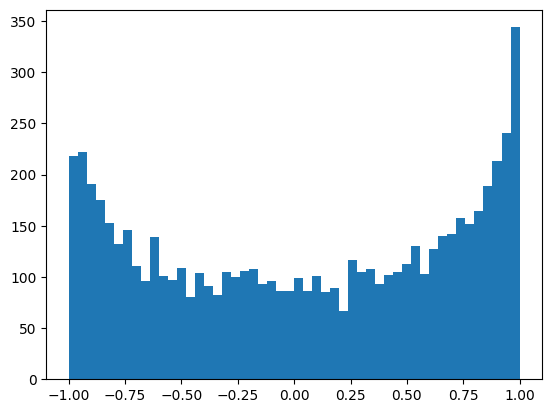

In [35]:
plt.hist(h.view(-1).tolist(),50)

(array([  1.,   1.,   0.,   1.,   0.,   1.,   3.,   3.,   8.,  11.,   8.,
         22.,  23.,  34.,  48.,  54.,  90., 141., 166., 211., 234., 274.,
        309., 329., 383., 438., 421., 398., 423., 401., 347., 329., 264.,
        224., 194., 140., 109.,  98.,  72.,  56.,  39.,  28.,  21.,  17.,
          9.,   9.,   4.,   1.,   1.,   2.]),
 array([-4.89476395, -4.71043654, -4.52610914, -4.34178174, -4.15745434,
        -3.97312694, -3.78879953, -3.60447213, -3.42014473, -3.23581733,
        -3.05148993, -2.86716252, -2.68283512, -2.49850772, -2.31418032,
        -2.12985291, -1.94552551, -1.76119811, -1.57687071, -1.39254331,
        -1.2082159 , -1.0238885 , -0.8395611 , -0.6552337 , -0.4709063 ,
        -0.28657889, -0.10225149,  0.08207591,  0.26640331,  0.45073071,
         0.63505812,  0.81938552,  1.00371292,  1.18804032,  1.37236773,
         1.55669513,  1.74102253,  1.92534993,  2.10967733,  2.29400474,
         2.47833214,  2.66265954,  2.84698694,  3.03131434,  3.21564175,
 

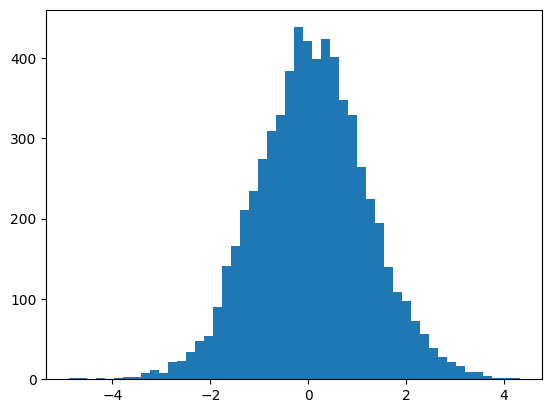

In [36]:
plt.hist(hpreact.view(-1).tolist(),50)

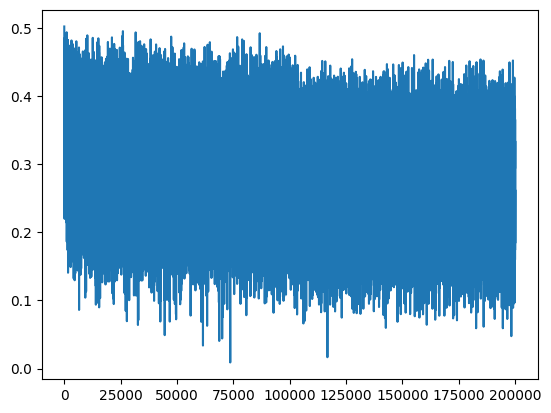

In [15]:
plt.plot(lossi)

In [38]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.8912400007247925
val 1.913430094718933


In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

chaudhachuwha.
khwwolhahavalahalalaloobahuha.
vachvachvahaichvathratchadhvalaleobvuchha.
vachvaganoohooovachvabi.
wauwahgavarivugha.
guvugulchad.
galiyoghahahyathavaraghovuchvaya.
vachovooba.
char.
vacharathae.
vaadhuuovaowoovaliyahuonichanaliyoonah.
vachahubhavyoh.
avidhachvahoovachvuda.
gavichawalochvaahunanadhachvalshawikhathwechahyah.
chawooga.
vathachuwahchaw.
chihhach.
valeoavinocharachawyohyahalyogu.
chauwaryochawyohhachavalalithhathuadhauwahishwadhvakahal.
vala.
